In [1]:
import numpy as np
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import brentq
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl 

def surface_cumulator(t, u, coords):
    """
    Parameters
    ----------
    t : array or None
        Parameter values associated with data coordinates. Should be sorted
        already. Pass None to use np.linspace(0, 1, n).
    u : array or None
        Parameter values associated with data coordinates. Should be sorted
        already. Pass None to use np.linspace(0, 1, n).
    coords : array
        Values of the curve at each t, u pair.

    Returns
    -------
    t, u : arrays
        As above.
    cum_S_t : array
        Cumulative surface area on [t[0], t], all u.
    cum_S_u : array
        Cumulative surface area on all t, [u[0], u].

    Evaluates the cumulative surface area at each coordinate.
    """

    if np.all(t) is None:
        t, _ = np.meshgrid(np.linspace(0, 1, coords.shape[-2]),
                           np.linspace(0, 1, coords.shape[-1]))
    if np.all(u) is None:
        _, u = np.meshgrid(np.linspace(0, 1, coords.shape[-2]),
                           np.linspace(0, 1, coords.shape[-1]))

    assert t.shape == u.shape == coords.shape[1:], \
        "Need same number of parameters as coordinates"
    delta_t_temp = np.diff(coords, axis=2)
    delta_u_temp = np.diff(coords, axis=1)

    # Pad with zeros so that small rand_S can still be interpd
    delta_t = np.zeros(coords.shape)
    delta_u = np.zeros(coords.shape)

    delta_t[:coords.shape[0], :coords.shape[1], 1:coords.shape[2]] = delta_t_temp
    delta_u[:coords.shape[0], 1:coords.shape[1], :coords.shape[2]] = delta_u_temp

    # Area of each parallelogram
    delta_S = np.linalg.norm(np.cross(delta_t, delta_u, 0, 0), axis=2)

    cum_S_t = np.cumsum(delta_S.sum(axis=0))
    cum_S_u = np.cumsum(delta_S.sum(axis=1))

    return t, u, cum_S_t, cum_S_u


def r_surface_from_data(n, t, u, coords, interp=True, kind='linear'):
    """
    Parameters
    ----------
    n : int
        Number of points to generate.
    t : array or None
        Parameter values associated with data coordinates. Should be sorted
        already. Pass None to use np.linspace(0, 1, n).
    u : array or None
        Parameter values associated with data coordinates. Should be sorted
        already. Pass None to use np.linspace(0, 1, n).
    coords : array
        Values of the curve at each t, u pair.
    interp : boolean
        Whether to generate random function values or not. Set to false if you
        have another way of evaluating the function.
    kind : str
        Interpolation method to be passed to scipy.interpolate.

    Returns
    -------
    (rand_coords : array)
        Random coordinates, if interp=True was passed.
    rand_t : array
        t-values associated with the coordinates.
    rand_u : array
        u_values associated with the coordinates.
    rand_S_t : array
        Cumulative area at each t-value over full range of u.
    rand_S_u : array
        Cumulative area at each u-value over full range of t.

    If the parameterizing function is known, use r_surface() instead, as the
    coordinates will be exactly computed from t instead of interpolating.
    """

    t, u, cum_S_t, cum_S_u = surface_cumulator(t, u, coords)

    # Random values
    rand_S_t = np.random.rand(n) * cum_S_t[-1]
    rand_S_u = np.random.rand(n) * cum_S_u[-1]

    # Find corresponding t-values by interpolation
    rand_t = interp1d(cum_S_t, t[0, :])(rand_S_t)
    rand_u = interp1d(cum_S_u, u[:, 0])(rand_S_u)

    if interp:
        # Interpolate coordinates, e.g. if func unknown

        rand_coords = np.empty([coords.shape[0], n])

        # One axis at a time, or else scipy throws dim mismatch
        for i in range(coords.shape[0]):
            f = interp2d(t, u, coords[i], kind=kind)

            # One point at time, or else scipy does a meshgrid
            for j in range(n):
                rand_coords[i, j] = f(rand_t[j], rand_u[j])

        return rand_coords, rand_t, rand_u, rand_S_t, rand_S_u

    else:
        return rand_t, rand_u, rand_S_t, rand_S_u


def r_surface(n, func, t0, t1, u0, u1, t_precision=25, u_precision=25):
    """
    Parameters
    ----------
    n : int
        Number of points to generate.
    func : function
        Parametric function describing the curve on which points should
        be generated.
    t0, t1, u0, u1 : ints or floats
        Range over which func is evaluated.
    t_precision, u_precision : ints
        Number of t-values at which func is evaluated when computing
        surface area.

    Returns
    -------
    rand_coords : array
        Random coordinates.
    rand_t : array
        t-values associated with the coordinates.
    rand_u : array
        u_values associated with the coordinates.
    rand_S_t : array
        Cumulative area at each t-value over full range of u.
    rand_S_u : array
        Cumulative area at each u-value over full range of t.

    Generates random points distributed uniformly over a parametric surface.
    """

    t, u = np.meshgrid(np.linspace(t0, t1, t_precision),
                       np.linspace(u0, u1, u_precision))
    coords = func(t, u)

    rand_t, rand_u, rand_S_t, rand_S_u = r_surface_from_data(n, t, u, coords, interp=False)
    rand_coords = func(rand_t, rand_u)

    return rand_coords, rand_t, rand_u, rand_S_t, rand_S_u


In [2]:
import numpy as np
import torch

def r_surface(n, func, t0, t1, u0, u1, t_precision=50, u_precision=50):
    t, u = np.meshgrid(np.linspace(t0, t1, t_precision),
                       np.linspace(u0, u1, u_precision))
    coords = func(t, u)

    # Compute cross product area estimates
    dt = np.zeros_like(coords)
    du = np.zeros_like(coords)
    dt[:, 1:, :] = np.diff(coords, axis=1)
    du[:, :, 1:] = np.diff(coords, axis=2)
    dS = np.linalg.norm(np.cross(dt, du, axis=0), axis=0)

    cum_S_t = np.cumsum(dS.sum(axis=0))
    cum_S_u = np.cumsum(dS.sum(axis=1))

    rand_S_t = np.random.rand(n) * cum_S_t[-1]
    rand_S_u = np.random.rand(n) * cum_S_u[-1]

    rand_t = np.interp(rand_S_t, cum_S_t, t[0])
    rand_u = np.interp(rand_S_u, cum_S_u, u[:, 0])

    rand_coords = func(rand_t, rand_u)
    return rand_coords, rand_t, rand_u, cum_S_t, cum_S_u

    import torch

def r_surface_torch(n, func, t0, t1, u0, u1, t_precision=50, u_precision=50, device='cpu'):
    # Create t, u grids
    t_vals = torch.linspace(t0, t1, t_precision, device=device)
    u_vals = torch.linspace(u0, u1, u_precision, device=device)
    t, u = torch.meshgrid(t_vals, u_vals, indexing='ij')  # (t_precision, u_precision)

    coords = func(t, u)  # (3, t_precision, u_precision)

    # Compute differential vectors
    dt = torch.zeros_like(coords)
    du = torch.zeros_like(coords)
    dt[:, 1:, :] = coords[:, 1:, :] - coords[:, :-1, :]
    du[:, :, 1:] = coords[:, :, 1:] - coords[:, :, :-1]

    dS = torch.norm(torch.cross(dt, du, dim=0), dim=0)  # (t_precision, u_precision)

    # Cumulative area for sampling
    cum_S_t = torch.cumsum(dS.sum(dim=1), dim=0)
    cum_S_u = torch.cumsum(dS.sum(dim=0), dim=0)

    rand_S_t = torch.rand(n, device=device) * cum_S_t[-1]
    rand_S_u = torch.rand(n, device=device) * cum_S_u[-1]

    def interp(x, xp, fp):
        idx = torch.searchsorted(xp, x, right=True).clamp(min=1, max=len(xp)-1)
        x0 = xp[idx - 1]
        x1 = xp[idx]
        y0 = fp[idx - 1]
        y1 = fp[idx]
        return y0 + (x - x0) * (y1 - y0) / (x1 - x0)

    rand_t = interp(rand_S_t, cum_S_t, t_vals)
    rand_u = interp(rand_S_u, cum_S_u, u_vals)

    rand_coords = func(rand_t, rand_u)  # (3, n)
    return rand_coords, rand_t, rand_u



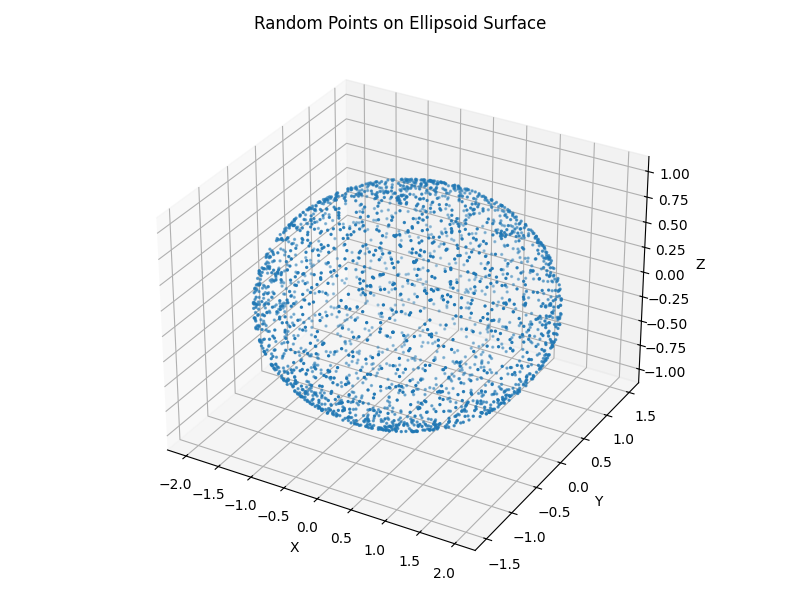

In [6]:
def ellipsoid_surface(theta, phi, a=1, b=1, c=1):
    x = a * np.sin(theta) * np.cos(phi)
    y = b * np.sin(theta) * np.sin(phi)
    z = c * np.cos(theta)
    return np.stack([x, y, z], axis=0)  # shape (3, len(theta), len(phi))

def ellipsoid_func_torch(t, u, a=1.0, b=1.0, c=1.0):
    x = a * torch.sin(t) * torch.cos(u)
    y = b * torch.sin(t) * torch.sin(u)
    z = c * torch.cos(t)
    return torch.stack([x, y, z], dim=0)  # shape (3, ...)

# Number of points to sample
m = 2500
a, b, c = 2.0, 1.5, 1.0

# Sample points on the ellipsoid
points, _, _ = r_surface_torch(
    m,
    lambda t, u: ellipsoid_func_torch(t, u, a, b, c),
    t0=0, t1=np.pi,
    u0=0, u1=2*np.pi,
    t_precision=100, u_precision=100
)

# points.shape = (3, m), transpose if needed
points = points.T  # shape (m, 3)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
ax.set_title("Random Points on Ellipsoid Surface")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


[[0. 0. 1.]]


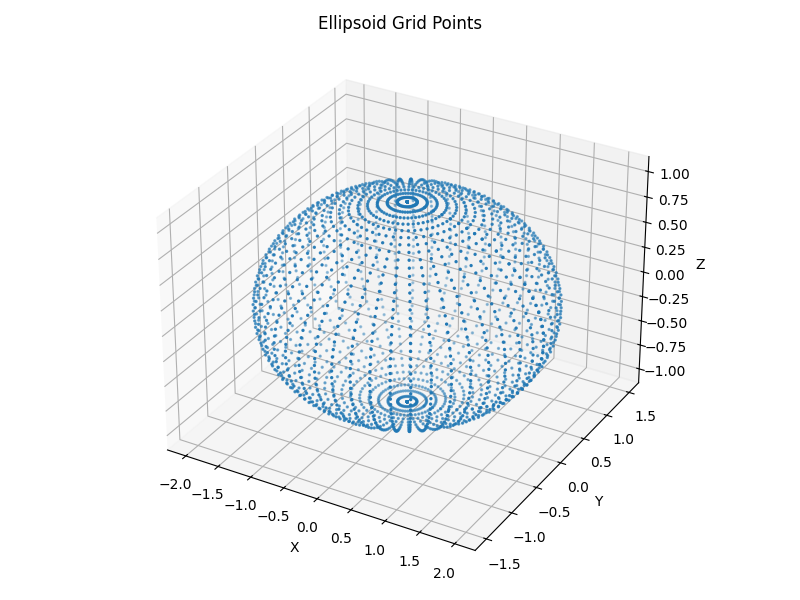

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ellipsoid_grid(a, b, c, n_theta=50, n_phi=50):
    """
    Generate a grid of points on the surface of an ellipsoid with semiaxes (a, b, c).
    
    Returns
    -------
    points : array of shape (n_theta * n_phi, 3)
        Flattened grid of 3D coordinates on the ellipsoid surface.
    """
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi)

    X = a * np.sin(theta) * np.cos(phi)
    Y = b * np.sin(theta) * np.sin(phi)
    Z = c * np.cos(theta)

    # Flatten and stack to shape (N, 3)
    points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)
    return points

# Generate points and plot
points = generate_ellipsoid_grid(a=2.0, b=1.5, c=1.0)
print(points[:1])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
ax.set_title("Ellipsoid Grid Points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()
